# Ablation study
Investigation of the improvement of (mdi-PLS) model performance upon sequential inclusion of domains

### Load modules

In [16]:
# --- system modules

import sys
import datetime
import os


# --- numerical modules

import numpy as np
import pandas as pd


# --- model building

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


# --- diPLS

import functions as fct
import dipals as ml
import utils 


# --- visualization and data modules
import matplotlib as mtply
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


plt.style.use("ggplot")
plt.rcParams.update({'font.size': 20})


### Prepare data

In [17]:

data_url = "NAnderson2020MendeleyMangoNIRData.csv"
data_raw = pd.read_csv(data_url,sep = ",", decimal = ".")
# data_raw.describe(include = 'all')

sou_filter = (data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "Caly")

tar_filters = []
tar_filters.append((data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "KP"))
tar_filters.append((data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "HG"))
tar_filters.append((data_raw["Season"]==2) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "KP"))
tar_filters.append((data_raw["Season"]==2) &  (data_raw["Set"] == "Tuning") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "HG"))
tar_filters.append((data_raw["Season"]==2) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "R2E2"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "KP"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "HG"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "R2E2"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Ripen") & (data_raw["Cultivar"] == "KP"))

# season 4
tar_test_filter = (data_raw["Set"]=="Val Ext") & (data_raw["Region"] == "NT") & ((data_raw["Type"] == "Hard Green") | (data_raw["Type"] == "Ripen") ) & ((data_raw["Cultivar"] == "Caly") | (data_raw["Cultivar"] == "KP") | (data_raw["Cultivar"] == "HG") | (data_raw["Cultivar"] == "R2E2"))

# data shapes
#print(sou_filter.head())
#print(sou_filter.sum(), [tt_filter.sum() for tt_filter in tar_filters],tar_test_filter.sum())

# Get data sets for each domain
data_sou = data_raw.loc[sou_filter]
data_tar_list = []
for tt_filter in tar_filters:    
    data_tar_list.append(data_raw.loc[tt_filter])
    
data_tar_test = data_raw.loc[tar_test_filter]

# Get matrices for each domain
wv_range_selected = np.arange(40,265) # 430-1100 nm
Xsou_cal = np.array(data_sou.iloc[:,17:-14])[:,wv_range_selected]
Ysou_cal = np.array(data_sou.iloc[:,8:9])

Xt_list = []
yt_list = []
for data_tar in data_tar_list:    
    Xt_list.append(np.array(data_tar.iloc[:,17:-14])[:,wv_range_selected])
    yt_list.append(np.array(data_tar.iloc[:,8:9]))

Xtar_test = np.array(data_tar_test.iloc[:,17:-14])[:,wv_range_selected]
Ytar_test = np.array(data_tar_test.iloc[:,8:9])
wv_range = np.array(data_sou.columns[17:-14]).astype(np.float64)[wv_range_selected]


X = Xsou_cal.copy()
Xs = X.copy()
Y = Ysou_cal.copy()

# For mdipls
target_domains = Xt_list.copy()

# For dipls with concatenation
Xtar_concat = np.concatenate(Xt_list, axis = 0) 
target_domains_concat = [Xtar_concat]
plt.show()


### mdi-PLS models

In [18]:
### Season cumulative ablation study (mdiPLS)

# Meta parameters
l = 1e7
lv = 8

# Fit mdi-PLS models
m_mdipls0 = ml.model(X, Y, Xs, target_domains, lv)      # including seasons 1-3
m_mdipls0.fit(l=[l], target_domain=0)

m_mdipls1 = ml.model(X, Y, Xs, target_domains[:2], lv)  # including season 1&2
m_mdipls1.fit(l=[l], target_domain=0)

m_mdipls2 = ml.model(X, Y, Xs, target_domains[:5], lv)  # including season 1
m_mdipls2.fit(l=[l], target_domain=0)


# Predictions
yhat_mdipls0, err_mdipls0 = m_mdipls0.predict(Xtar_test, Ytar_test)
yhat_mdipls1, err_mdipls1 = m_mdipls1.predict(Xtar_test, Ytar_test)
yhat_mdipls2, err_mdipls2 = m_mdipls2.predict(Xtar_test, Ytar_test)

# Performance metrics
rmsep_mdipls0, bias_mdipls0, r2p_mdipls0, sep_mdipls0 = utils.performance_measures(Ytar_test, yhat_mdipls0)
rmsep_mdipls1, bias_mdipls1, r2p_mdipls1, sep_mdipls1 = utils.performance_measures(Ytar_test, yhat_mdipls1)
rmsep_mdipls2, bias_mdipls2, r2p_mdipls2, sep_mdipls2 = utils.performance_measures(Ytar_test, yhat_mdipls2)

seasons = ["1", "1-2", "1-2-3"]
RMSEP = [rmsep_mdipls1,rmsep_mdipls2,rmsep_mdipls0]
BIAS = [bias_mdipls1,bias_mdipls2,bias_mdipls0]
R2P = [r2p_mdipls1,r2p_mdipls2,r2p_mdipls0]
SEP = [sep_mdipls1,sep_mdipls2,sep_mdipls0]

### Supervised PLS models

In [19]:
### Season cumulative ablation study supervised PLS

# Meta parameters
l = 0
lv = 19

# Prepare data
X_current = np.concatenate([X] + Xt_list, axis = 0)
Y_current = np.concatenate([Y] + yt_list, axis = 0)
Xs_current = X_current.copy()

# Fit PLS models
m_pls0 = ml.model(X_current, Y_current, Xs_current, target_domains, lv) # all target domains
m_pls0.fit(l=[l], target_domain=0)

X_current = np.concatenate([X] + Xt_list[:2], axis = 0)
Y_current = np.concatenate([Y] + yt_list[:2], axis = 0)
Xs_current = X_current.copy()

m_pls1 = ml.model(X_current, Y_current, Xs_current, target_domains[:2], lv)
m_pls1.fit(l=[l], target_domain=0)

X_current = np.concatenate([X] + Xt_list[:5], axis = 0)
Y_current = np.concatenate([Y] + yt_list[:5], axis = 0)
Xs_current = X_current.copy()

m_pls2 = ml.model(X_current, Y_current, Xs_current, target_domains[:5], lv)
m_pls2.fit(l=[l], target_domain=0)

# Predictions
yhat_pls0, err_pls0 = m_pls0.predict(Xtar_test, Ytar_test)
yhat_pls1, err_pls1 = m_pls1.predict(Xtar_test, Ytar_test)
yhat_pls2, err_pls2 = m_pls2.predict(Xtar_test, Ytar_test)

# Performance metrics
rmsep_pls0, bias_pls0, r2p_pls0, sep_pls0 = utils.performance_measures(Ytar_test, yhat_pls0)
rmsep_pls1, bias_pls1, r2p_pls1, sep_pls1 = utils.performance_measures(Ytar_test, yhat_pls1)
rmsep_pls2, bias_pls2, r2p_pls2, sep_pls2 = utils.performance_measures(Ytar_test, yhat_pls2)

seasons = ["1", "1-2", "1-2-3"]
RMSEP_pls = [rmsep_pls1,rmsep_pls2,rmsep_pls0]
BIAS_pls = [bias_pls1,bias_pls2,bias_pls0]
R2P_pls = [r2p_pls1,r2p_pls2,r2p_pls0]
SEP_pls = [sep_pls1,sep_pls2,sep_pls0]

### Plot results

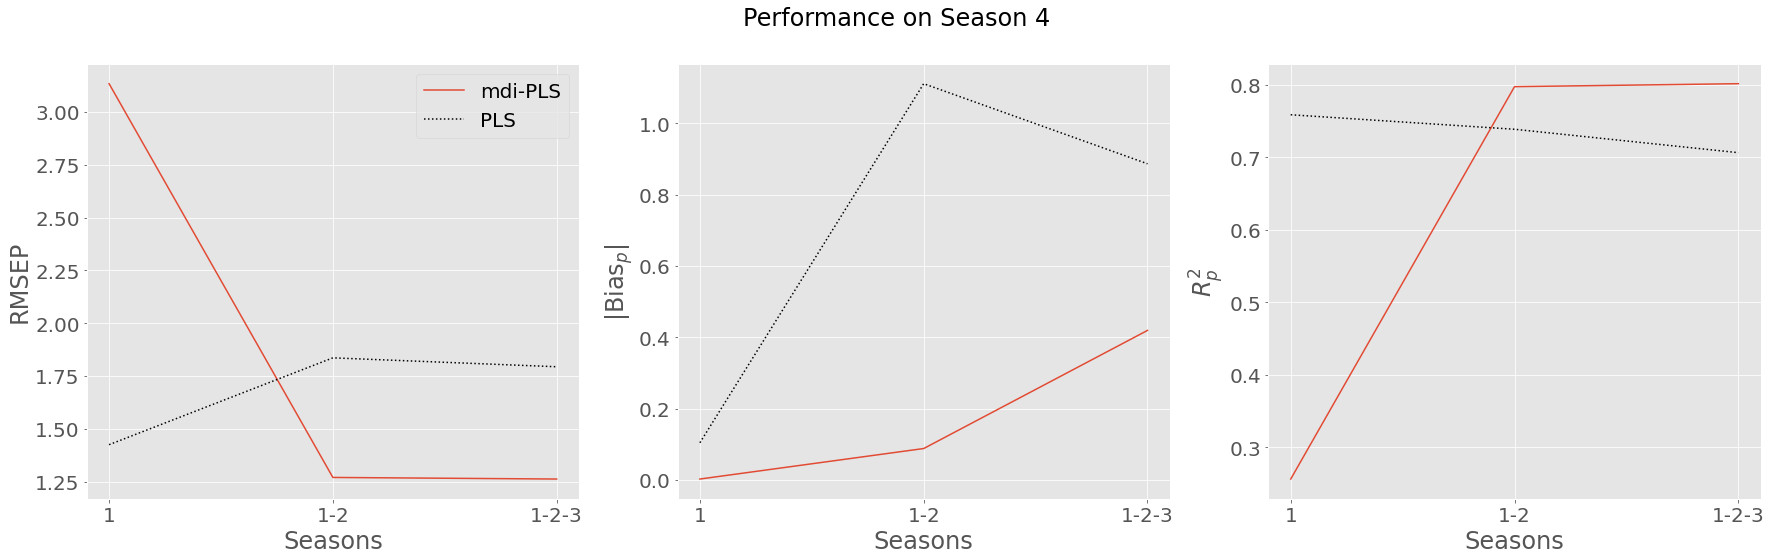

In [20]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.plot(seasons,RMSEP, label = "mdi-PLS")
plt.plot(seasons,RMSEP_pls,c='k', linestyle=':', label = "PLS")
plt.ylabel("RMSEP")
plt.legend(loc=0)
plt.xlabel("Seasons")

plt.subplot(132)
plt.plot(seasons,np.abs(BIAS))
plt.plot(seasons,np.abs(BIAS_pls),c='k', linestyle=':')
plt.ylabel("|Bias$_p$|")
plt.xlabel("Seasons")

plt.subplot(133)
plt.plot(seasons,R2P)
plt.plot(seasons,R2P_pls,c='k', linestyle=':')
plt.ylabel("$R^2_p$")
plt.xlabel("Seasons")

plt.suptitle("Performance on Season 4")
plt.savefig("../figures/mango_season_effect.png")

plt.show()